# Bayesian Data analysis with Markov Chain Monte Carlo methods

### Outline

- Introduction to Bayesian Data analysis
- Example I: Fitting parameters of a Normal distribution 
- Example II: Linear Regression
- MCMC
    - Metropolis-Hastings algorithm
- Example III: Discovering dark energy

You can clone this notebook from https://github.com/Supranta/bayesian_data_analysis/

### Some Useful texts/reviews/popular books on the subject (a biased selection)

<font size="3.7">Reviews:
- $\textit{Data analysis recipes: Fitting a model to data}$, Hogg, Bovy, Lang, arXiV:1008.4686, Example of fitting straight line is inspired from this review
- $\textit{Data Analysis Recipes: Using Markov Chain Monte Carlo}$, Hogg, Foreman-Mackey, arXiV:1710.06068


Textbooks:
- $\textit{Information Theory, Inference, and Learning Algorithms}$, Mackay, Cambridge University Press, Good for understanding different MCMC algorithms and topics such as Bayesian model comparison.
- $\textit{Statistics, Data Mining, and Machine Learning in Astronomy}$, Ivecic, Connolly, Vanderplas, Gray, Princeton University Press, I like the hands-on approach of this book

Popular books:
- $\textit{Signal and the Noise}$, Nate Silver
- $\textit{The Theory That Would Not Die: How Bayes' Rule Cracked the Enigma Code, Hunted Down Russian Submarines, and Emerged Triumphant from Two Centuries of Controversy}$, Sharon Bertsch McGrayne</font>

## Bayesian Data Analysis

<font size="3.7">Data is worth nothing on its own. We need some way to make useful inference about the world from data. Given the data, a physicist wants to make inferences on the physical laws governing nature, companies want to make inferences on the behaviour of its customers from the online data footprint. 

In the era of "Big Data", we have huge data sets of various kinds. One needs sophisticated analysis method to make accurate predictions.
\

According to the text-book, "Bayesian Data Analysis", Bayesian data analysis can be thought of in three steps:

$\textit{i)}$ Setting up a probability Model. Modelling the processes involved in the systems we care about. Domain knowledge specific. For example, 
- astrophysicists modelling galaxy formation, 
- epidemiologist modelling disease spread, 
- trading forecasts in finance,
- election forecasts

$\textrm{ONE ALWAYS NEEDS A MODEL TO DO BAYESIAN DATA ANALYSIS!!}$

A related quote: $\textit{"All models are wrong, but some are useful"}$

Sometimes the modelling is implicit. My personal view is that it helps to spell out all the model assumptions. It helps to quantify, e.g., how wrong our model is.

$\textit{ii)}$ Conditioning on observed data and fitting model parameters. Depending on the complexity of the model, different fitting methods could be more appropriate. The main topic of these lectures, MCMC techniques, fit into this category.

Remember, the models usually come with model parameters which needs to be fit.

$\textit{iii)}$ Making interpretations of the results from Step $(\textit{ii})$. e.g, how well does the model fit the data, sensitivity to the model assumptions of Step $(\textit{i})$.

$\textbf{Bayes Theorem}$:

Starting point of Bayesian data analysis is the Bayes' Theorem, which lets us write one conditional probability in terms of another

\begin{equation}
    \mathcal{P}(x|y) = \frac{\mathcal{P}(y|x)\mathcal{P}(x)}{\mathcal{P}(y)},
\end{equation}

This follows from basic probability and is uncontroversial. 

In Bayesian data analysis, one uses Bayes' theorem to write

\begin{equation}
    \mathcal{P}(H|D) = \frac{\mathcal{P}(D|H)\mathcal{P}(H)}{\mathcal{P}(D)},
\end{equation}

where, $H$ is the $\textit{hypothesis}$ and $D$ as the $\textit{data}$. One makes the philosophical jump of interpreting the probability $\mathcal{P}(H|D)$ as the degree of belief in the hypothesis.

$H$ usually contains the theoretical modelling of the data. Usually, one has a theoretical model with a few parameters, $\theta$, which is inferred using the above equation. The left-hand side then becomes the 'posterior' on the model parameters and we can rewrite the equation as, 

\begin{equation}
    \mathcal{P}(\theta|D) = \frac{\mathcal{P}(D|\theta)\mathcal{P}(\theta)}{\mathcal{P}(D)},
\end{equation}

$\mathcal{P}(D|\theta)$ is called the $\textit{Likelihood}$ of the data given a model. Note that it is $\textbf{not}$ a probability distribution in the model parameters, $\theta$. It is most useful to think of the likelihood as a function of $\theta$. Calculating this requires incorporating the theoretical modelling (both physical and probabilistic) of the data.

$\mathcal{P}(\theta)$: The prior on the model parameters. One great sin: Not thinking about the prior 

$\mathcal{P}(\theta|D)$ is the $\textit{posterior}$ on the model parameters. This is the quantity which gives a constraint on the model parameters $\theta$ given the data.</font>

## Example I: Analytic posteriors for fitting the parameters of a Gaussian distribution

<font size="3.7">Suppose our data points $\{x_i\}$ are independent and drawn from a Normal distribution, $\mathcal{N}(\mu, \sigma^2)$. 


Because of independence: $\mathcal{P}(\{x_i\}|\theta) = \prod_{i=1}^{N}\mathcal{P}(x_i|\theta)$. Here $\theta$ corresponds to the model parameters. In this case it is the mean and the standard deviation of the Normal distribution.

Now model the likelihood of the individual points with a normal distribution, $\mathcal{P}(x_i|\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp \bigg(-\frac{(x_i - \mu)^2}{2\sigma^2}\bigg)$ 

$\textbf{Data}: \{x_i\}$ 

$\textbf{Model assumptions}: \textrm{independent probability, Gaussian likelihood}$

$\textbf{Model Parameters}: \mu, \sigma$

Note that, here the model is indeed the right model. But usually we don't know the exact distributions the data drawn from.

Using Bayes Theorem, the posterior probability for the parameters is given as, 

\begin{align}
    \mathcal{P}(\mu, \sigma|\{x_i\}) &= \frac{\mathcal{P}(\{x_i\}|\mu, \sigma)\mathcal{P}(\mu, \sigma)}{\mathcal{P}(\{x_i\})}\\
    &\propto \mathcal{P}(\mu, \sigma) \prod_{i=1}^{N}\mathcal{P}(x_i|\theta)
\end{align}

Here we dropped the denominator as it does not depend on $\mu, \sigma$. We focus on the relative probability here.

We will try to simulate this on a true distribution with $\mu_{\textrm{true}} = 0, \sigma_{\textrm{true}} = 1$
</font>

In [1]:
# Import useful packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Latexify your plots

plt.rc('text',usetex=True)
plt.rc('font',family='serif')

Draw a few ($\textrm{N_POINTS}$) data points from the true distribution (with $\mu_{\textrm{true}} = 0, \sigma_{\textrm{true}} = 1$) and then fit the parameters of the Gaussian distribution

In [3]:
N_POINTS = 30
x_data = np.random.normal(0., 1., N_POINTS)

In [4]:
# For plotting the true distribution on the histogram
x_plot = np.linspace(-3.0, 3.0, 1000)
y_plot = 1./np.sqrt(2*np.pi)*np.exp(-0.5 * x_plot * x_plot)

In [5]:
FONTSIZE=16

In [6]:
print(x_data)

[ 0.9990042  -1.02692214 -0.06463981 -0.9848336   0.80620881  1.32174908
 -0.93440572  0.0500593   0.82777403  1.39679177  0.00847138  0.28817261
 -0.74670023 -0.88342188  0.44639897 -0.25652551  0.22902807 -0.22202221
  1.01263033 -0.16737122 -1.63189574 -1.27207498 -0.44491391  0.970174
 -0.87672604 -0.75459906 -0.35547811  2.21240508 -1.40076663 -0.19986952]


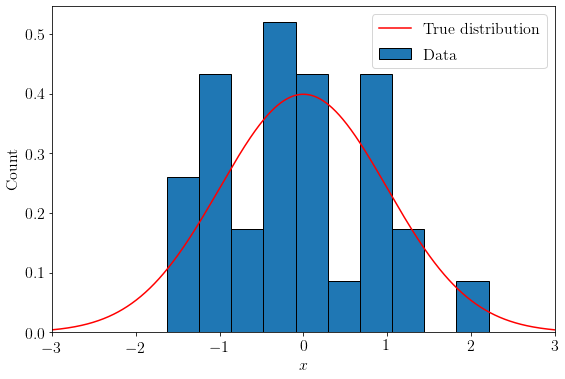

In [7]:
# Visualize the data in a histogram

plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlim(-3,3)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('Count', fontsize=FONTSIZE)

plt.hist(x_data, density=True, edgecolor='k', label='Data')
plt.plot(x_plot, y_plot, 'r', label='True distribution')

plt.legend(fontsize=FONTSIZE)
plt.show()

$\underline{\textbf{Inference task at hand}}:$ Given this data set, estimate the mean and standard deviation of the underlying Gaussian distribution.

$\underline{\textit{Note}}:$ Computationally, it is convenient to work with log-likelihood and log-probabilities. So the computational implementation of these quantities are in logarithms.

In [8]:
# Define the prior, likelihood and the posterior for this inference

def ln_prior(mu, sigma):
    return 0.
# This is an example of a BAD prior. This is uniform everywhere and therefore not normalizable. 
# We can get away with it because, the likelihood dominates everywhere.

def ln_likelihood(x_data, mu, sigma):
    return -0.5 * np.sum((x_data - mu)**2 / sigma / sigma + np.log(2 * np.pi * sigma * sigma))

def ln_posterior(x_data, mu, sigma):
    return ln_prior(mu, sigma) + ln_likelihood(x_data, mu, sigma)

We will compute the posterior by making a grid of $\mu$ and $\sigma$.

In [9]:
N_MU_POINTS = 201
N_SIGMA_POINTS = 151

mu_grid = np.linspace(-1.5, 1.5, N_MU_POINTS)
sigma_grid = np.linspace(0.5, 2.0, N_SIGMA_POINTS)

In [10]:
# Initialize arrays to calculate the posteriors. 

ln_posterior_grid = np.zeros((N_MU_POINTS, N_SIGMA_POINTS))
ln_posterior_sigma_fixed = np.zeros(N_MU_POINTS)
ln_posterior_mu_fixed = np.zeros(N_SIGMA_POINTS)

We will also compute the conditional probability by fixing the true value of one parameter at a time.

In [11]:
for i in range(N_MU_POINTS):
    ln_posterior_sigma_fixed[i] = ln_posterior(x_data, mu_grid[i], 1.)
    for j in range(N_SIGMA_POINTS):
        ln_posterior_grid[i,j] = ln_posterior(x_data, mu_grid[i], sigma_grid[j])
        
for j in range(N_SIGMA_POINTS):
    ln_posterior_mu_fixed[j]    = ln_posterior(x_data, 0., sigma_grid[j])

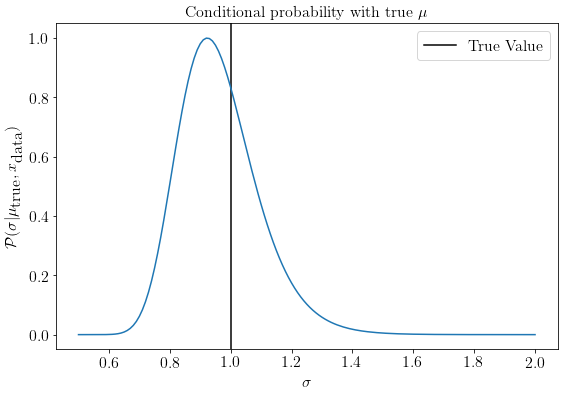

In [12]:
# Plot of the conditional posterior of sigma by assuming the true value of mu

plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.title('Conditional probability with true $\mu$', fontsize=FONTSIZE)
plt.xlabel('$\sigma$', fontsize=FONTSIZE)
plt.ylabel(r'$\mathcal{P}(\sigma|\mu_{\textrm{true}}, x_{\textrm{data}})$', fontsize=FONTSIZE)
plt.axvline(1.0, color='k', label='True Value')
plt.plot(sigma_grid, np.exp(ln_posterior_mu_fixed - np.max(ln_posterior_mu_fixed)))
plt.legend(fontsize=FONTSIZE)
plt.show()

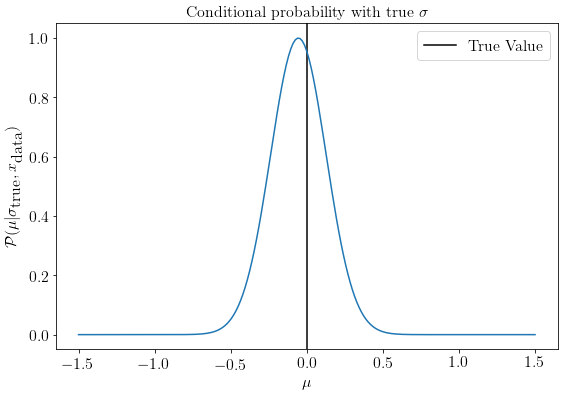

In [13]:
# Plot of the conditional posterior of mu by assuming the true value of sigma

plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.title('Conditional probability with true $\sigma$', fontsize=FONTSIZE)
plt.xlabel('$\mu$', fontsize=FONTSIZE)
plt.ylabel(r'$\mathcal{P}(\mu|\sigma_{\textrm{true}}, x_{\textrm{data}})$', fontsize=FONTSIZE)
plt.axvline(0.0, color='k', label='True Value')
plt.plot(mu_grid, np.exp(ln_posterior_sigma_fixed - np.max(ln_posterior_sigma_fixed)))
plt.legend(fontsize=FONTSIZE)
plt.show()

Plot the two dimensional joint posteriors

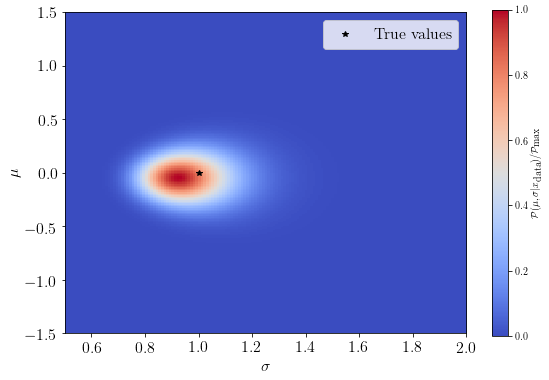

In [14]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$\sigma$', fontsize=FONTSIZE)
plt.ylabel('$\mu$', fontsize=FONTSIZE)
plt.imshow(np.exp(ln_posterior_grid[::-1] - np.max(ln_posterior_grid)), extent=(0.5, 2.0, -1.5, 1.5), cmap=cm.coolwarm, aspect=0.4)
plt.plot(1., 0., 'k*', label='True values')
plt.colorbar(label=r'$\mathcal{P}(\mu, \sigma| x_{\textrm{data}}) / \mathcal{P}_{\textrm{max}}$')
plt.legend(fontsize=FONTSIZE)
plt.show()

Check the maximum likelihood points

In [15]:
print("Maximum likelihood points: ")
print("mu_ML: %2.2f"%(mu_grid[np.argmax(ln_posterior_grid)//N_SIGMA_POINTS]))
print("sigma_ML: %2.2f"%(sigma_grid[np.argmax(ln_posterior_grid)%N_SIGMA_POINTS]))

Maximum likelihood points: 
mu_ML: -0.06
sigma_ML: 0.92


Check the value of the posterior at the true parameter values

In [16]:
print(mu_grid[100], sigma_grid[50])
print("Posterior value at the true parameter values: %2.3f"%(np.exp(ln_posterior_grid[100, 50] - np.max(ln_posterior_grid))))

0.0 1.0
Posterior value at the true parameter values: 0.790


To do this in high dimensions is very difficult. $100$ grid points in each dimensions for a 6 dimensional problem requires $100^6 = 10^{12}$ function evaluations. Need clever techniques to do this faster.

## Example II: Fitting a straight line a.k.a Linear regression

<font size="3.7">Now let us consider an example which is more real with many applications in various fields. That is the problem of fiiting a straight line to a data set, also called as linear regression. Linear regression involves fitting a straight line to the data, $\{x_i, y_i\}$. This is the ideal inference task for using Bayesian data analysis.

Just as the last example, we will simulate an idealized dataset of points.</font>

In [17]:
slope_true = 2.1
intercept_true = 5
N_DATA = 5
x_data = np.random.uniform(-2.,2., N_DATA)
y_data = slope_true * x_data + intercept_true + np.random.normal(size=N_DATA)

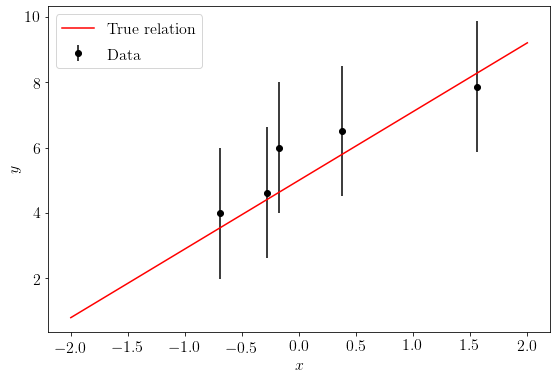

In [18]:
plt.figure(figsize=(9,6))

x_plot = np.linspace(-2.,2.,2)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

<font size="3.7">In this example, we have a perfect knowledge of the $x$-value of the data points. 

In the modelling aspect, we incoporate the knowledge that the relationship between $x$ and $y$ is linear. This model has two parameters, the slope $(m)$ and the intercept $(c)$. 

The stochasticity in the linear relationship is obtained by adding a Gaussian noise of standard deviation, $\sigma = 1$. For this example, we assume that we have a perfect understanding of the noise and therefore will not treat the scatter as a parameter.

Assuming the linear model, the posterior can be written as, 

\begin{equation}
\mathcal{P}(m, c|\{x_i\}, \{y_i\}) \propto \mathcal{P}(\{x_i\}, \{y_i\}|m, c) \mathcal{P}(m,c),
\end{equation}
where, we have ignored the denominator as it does not depend on the parameters of interest. The likelihood is given by, 

\begin{equation}
\mathcal{P}(\{x_i\}, \{y_i\}|m, c) = \prod_{i=1}^{N_{\text{points}}}\frac{1}{\sqrt{2\pi}}\exp\bigg(-\frac{(y_i - y^{\text{model}}_i(x_i, m, c))^2}{2}\bigg)
\end{equation}
where, 
\begin{equation}
y^{\text{model}}_i(x_i, m, c)) = m x_i +c
\end{equation}

We have modelled the noise in the linear modelled with an Gaussian likelihood. In this case, this is true by definition. For most applications (although not all), Central limit theorem justifies the use of Gaussian likelihood for modelling the noise.

Assuming a uniform prior on $m,c$, the posterior has the same functional form as the likelihood. 

Consider therefore the log-posterior, 

\begin{equation}
\log\mathcal{P}(m, c|\{x_i\}, \{y_i\}) = \sum_{i=1}^{N_{\text{points}}}\frac{(y_i - y^{\text{model}}_i(x_i, m, c))^2}{2} + \text{constant}
\end{equation}

Maximizing this function is the same as the least squares regression. But we now have a solid footing in probability.</font>

<font size="3.7">$\underline{\textit{A related note}}$: There are other popular forms of regression based on regularization, such as the Ridge regression and the Lasso regression. These methods are more robust to outliers in the data. These methods can be thought of in the Bayesian language as choosing different priors on the parameters. (A normal prior for ridge regression and an exponential prior for Lasso regression).

In Ridge regression, the objective function is, 

\begin{equation}
\sum_{i=1}^{N_{\text{points}}}\frac{(y_i - y^{\text{model}}_i(x_i, m, c))^2}{2} + \frac{\lambda_m}{2} m^2 + \frac{\lambda_c}{2} c^2 + \text{constant}. 
\end{equation}

Therefore, we can think of Ridge regression as adding a normal prior, $\mathcal{P}(m,c) = \exp\bigg(-\frac{\lambda_m m^2}{2} - \frac{\lambda_c c^2}{2}\bigg)$ to the usual linear regression.

In Lasso regression, the objective function is, 

\begin{equation}
\sum_{i=1}^{N_{\text{points}}}\frac{(y_i - y^{\text{model}}_i(x_i, m, c))^2}{2} + \lambda_m |m| + \lambda_c |c| + \text{constant} 
\end{equation}

Therefore, we can think of Lasso regression as adding an exponential prior, $\mathcal{P}(m,c) = \exp(-\lambda_m |m| - \lambda_s |c|)$ to the usual linear regression. 

$\lambda_m$ and $\lambda_c$ are tunable hyperparameters<font>

<font size="3.7">Let us now fit the slope and the intercept for the linear relation above in the same way as before, i.e., Calculate the posterior on the grid</font>

In [19]:
def ln_prior_regression(theta):
    m, c = theta
    if(np.abs(m) > 10.):
        return -np.inf
    if(np.abs(c) > 20.):
        return -np.inf
    return 0.
# Unlike last time, this prior is normalizable. However, it is still quite arbitrary.
# The prior may seem to be an arbitrary function, but it depends on the problem at hand. 
# Often, there are physical considerations that guide what the prior should be.

def ln_likelihood_regression(theta, x_data, y_data):
    m, c = theta
    y_model = m*x_data + c
    return np.sum(-0.5*(y_model - y_data)**2)

def ln_posterior_regression(theta, x_data, y_data):
    m, c = theta
    return ln_likelihood_regression(theta, x_data, y_data) + ln_prior_regression(theta)

In [20]:
# Make a grid of m and c

N_M_POINTS = 201
N_C_POINTS = 201

m_grid = np.linspace(-5.0, 5.0, N_M_POINTS)
c_grid = np.linspace(-10.0, 10.0, N_C_POINTS)

In [21]:
ln_posterior_grid_regression = np.zeros((N_M_POINTS, N_C_POINTS))

In [22]:
for i in range(N_M_POINTS):
    for j in range(N_C_POINTS):
        theta_ij = m_grid[i], c_grid[j]
        ln_posterior_grid_regression[i,j] = ln_posterior_regression(theta_ij, x_data, y_data)

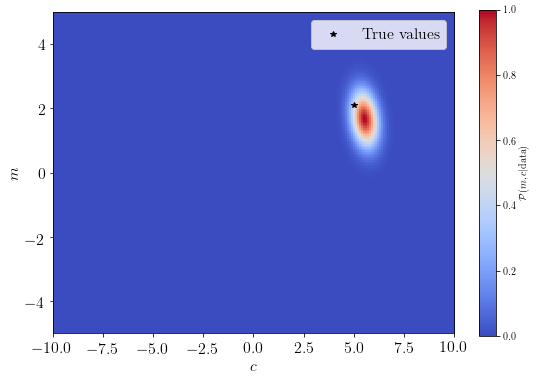

In [23]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$c$', fontsize=FONTSIZE)
plt.ylabel('$m$', fontsize=FONTSIZE)
plt.imshow(np.exp(ln_posterior_grid_regression[::-1] - np.max(ln_posterior_grid_regression)), extent=(-10, 10., -5., 5.), cmap=cm.coolwarm, aspect=1.6)
plt.plot(intercept_true, slope_true, 'k*', label='True values')
plt.colorbar(label=r'$\mathcal{P}(m, c| \textrm{data})$')
plt.legend(fontsize=FONTSIZE)
plt.show()

In [24]:
# Get the index of the maximum a posteriori point

max_m_ind, max_c_ind = np.unravel_index(ln_posterior_grid_regression.argmax(), ln_posterior_grid_regression.shape)

In [25]:
# Find the maximum a posteriori point

m_ML = m_grid[max_m_ind]
c_ML = c_grid[max_c_ind]
print("Maximum likelihood points:")
print("Slope (max. likelihood): %2.2f"%(m_ML))
print("Intercept (max. likelihood): %2.2f"%(c_ML))

Maximum likelihood points:
Slope (max. likelihood): 1.65
Intercept (max. likelihood): 5.50


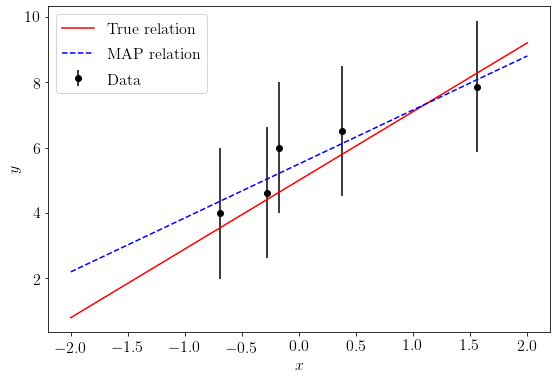

In [26]:
# Compare the true relation and the MAP estimate

plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.plot(x_plot, m_ML * x_plot + c_ML, 'b--',label='MAP relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

<font size="3.7">For the two examples considered so far, calculating the posterior on a 100 x 100 grid involves $10^4$ likelihood evaluations. However, this strategy quickly becomes unfeasible when considering higher dimensional parameter space. For example if you consider a grid of 100 points in each dimension for a 7-dimensional parameter space, the number of likelihood evaluations would be $10^{14}$, which is unfeasible.

So we need more sophisticated techniques to calculate the posterior. One such technique is the Markov Chain Monte Carlo method.</font>

## Markov Chain Monte Carlo (MCMC)

<font size="3.7">As the name suggests, Markov Chain Monte Carlo methods have two parts: $\textit{i)}$ Markov Chain $\textit{ii)}$ Monte carlo

The Markov Chain part refers to the Markov process that is used for simulating the posterior of interest. 

$\textit{Definition}:$ A Markov process is a stochastic process, where the probability of the next step only depends on the current state of the chain. That is, it lives in the present. No memory of the past. 

The Monte Carlo part refers to the use of random number generators to simulate a given probability function.

The goal of Markov Chain Monte Carlo techniques are to use a stationary (no dependence on time) Markov Chain to simulate a posterior of interest. There are many MCMC algorithms. The simplest of these algorithms is the Metropolis-Hastings algorithm. We will explore other algorithms in the next lectures.

$\underline{\textit{Historical anecdote}}:$ The Metropolis algorithm was first proposed in Metropolis, et. al. in 1953. It is however now widely accepted that, the development was actually led by the physicist couple, Arianna and Marshall Rosenbluth.</font>

### Metropolis-Hastings (MH) algorithm

<font size="3.7">The Metropolis-Hastings algorithm consists of the following steps.

- Step 1: Initialize the MCMC chain at a point, $\Theta_0$, in the parameter space.
- Step 2: ($\textit{Proposal}$) Propose a new point, $\Theta_{\textrm{new}}$, from the proposal distribution, $\mathcal{N}(\Theta_0, \sigma_s)$, where, $\Theta_0$ is the current point in the parameter space. $\sigma_s$ is the step size. This is an important hyperparameter in running the MCMC simulations.
- Step 3: ($\textit{Accept-reject scheme}$) Compare the posterior ratios of the proposed point and the current point. 

Sample a point $U \sim \textrm{Unif}(0, 1)$. If $U$ < min$(1,\frac{\mathcal{P}(Θ_{\textrm{new}}|D)}{\mathcal{P}(Θ_0|D)})$, the proposed point is accepted and is set as the next point in the chain. Otherwise, the next point in the chain is set retained as the current point.
- Step 4: Repeat Steps 2 and 3 for $N$ times, where you propose the $(t+1)$-th step, $\Theta_{t+1}$ from $\mathcal{N}(\Theta_t, \sigma_s)$ and accept or reject the new point based on Step 3. This finally yields us a chain of length $N$.

We will not show today that this yields a stationary distribution. Nonetheless, it is easy to show by considering the transition probability.</font>

#### Implementation

We will implement a general purpose Metropolis-Hastings sampler, which we will use to sample the slope and intercept of the linear regression example.

In [28]:
class MH_sampler():
    """
    A class for doing Metroolis-Hastings Sampling
    :param ndim: Dimension of the parameter space being sampled
    :param lnprob: The log-posterior function.
    :param step_size: Initial Step size
    :param lnprob_args: (optional) extra positional arguments for the function lnprob
    """

    def __init__(self, ndim, lnprob, lnprob_args=[]):
        self.ndim = ndim
        self.lnprob = lnprob
        self.lnprob_args = lnprob_args

    def sample(self, init_pos, step_size_init, N_ITERATIONS=1000):
        """
        Samples the parameter space 'N_ITERATIONS' times
        :param init_pos: (1D Array of size ndim) The initial guess from where the chain is started
        :param step_size_init: (1D Array of size ndim) Initial guess for the size of a step-out
        :param N_ITERATIONS: Number of interations of sampling. Default is 1000.
        """
        assert init_pos.shape[0] == self.ndim, "init_pos must be an 1-D array of size n_dim"
        assert step_size_init.shape[0] == self.ndim, "step_size_init must be an 1-D array of size n_dim"

        self._chain = np.zeros((N_ITERATIONS, self.ndim))
        self._posterior = np.zeros(N_ITERATIONS)
        self._chain[0, :] = init_pos
        self.num_iterations = N_ITERATIONS
        self.step_size = step_size_init
        
        x = init_pos
        
        for i in range(N_ITERATIONS): 
            x = self.MH_one_step(x)
            self._chain[i] = x
            self._posterior[i] = self.get_lnprob(x)

    def MH_one_step(self, x):
        """
        """
        # Propose a new point with a Gaussian step
        x_proposed = x + np.random.multivariate_normal(np.zeros(2),cov=np.diag(self.step_size))
        
        # Get the value of the posterior at the old point and the proposed point. Also their difference
        ln_prob_old = self.get_lnprob(x)
        ln_prob_new = self.get_lnprob(x_proposed)
        
        delta_ln_prob = ln_prob_new - ln_prob_old
        
        # accept or reject the proposed point according to the scheme mentioned above
        if(delta_ln_prob > 0):
            x_new = x_proposed
        else:
            u = np.random.uniform()
            if(np.log(u) > delta_ln_prob):
                x_new = x
            else:
                x_new = x_proposed
        
        return x_new

    @property
    def chain(self):
        """
        Return the chain of the sampler.
        """
        return self._chain

    @property
    def posterior(self):
        """
        Return the posterior of the sampler.
        """
        return self._posterior

    def get_lnprob(self, x):
        """Return lnprob at the given position."""
        return self.lnprob(x, *self.lnprob_args)

In [29]:
# Initialize the MH sampler using the log posterior for regression and feeding in the simulated data

regression_mh_sampler = MH_sampler(2, ln_posterior_regression, (x_data, y_data,))

In [49]:
# Initialize the chain at (m,c)=(0,0)
starting_pos = np.array([0.0, 0.0])

# We use step sizes of 0.1 in both directions. 
# We will try to look at the effect of choosing step sizes that are too large or too small.
step_size = 0.1 * np.ones(2)

# Run the sampler for 5000 times
regression_mh_sampler.sample(starting_pos, step_size, 5000)

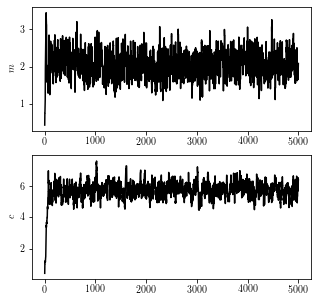

In [50]:
f, ax = plt.subplots(2,1,figsize=(5,5))

ax[0].set_ylabel('$m$')
ax[1].set_ylabel('$c$')
ax[0].plot(regression_mh_sampler.chain.T[0], 'k-')
ax[1].plot(regression_mh_sampler.chain.T[1], 'k-')

plt.show()

In [48]:
N_BURN_IN = 200
samples = regression_mh_sampler.chain[N_BURN_IN:]

In [33]:
sample_mean = np.mean(samples, axis=0)
sample_std = np.std(samples, axis=0)

In [34]:
print("Inferred value of the slope: %2.3f +/- %2.3f"%(sample_mean[0], sample_std[0]))
print("Inferred value of the intercept: %2.3f +/- %2.3f"%(sample_mean[1], sample_std[1]))

Inferred value of the slope: 2.050 +/- 0.353
Inferred value of the intercept: 5.786 +/- 0.463


We get an error estimates on the inferred parameters for free!!!!

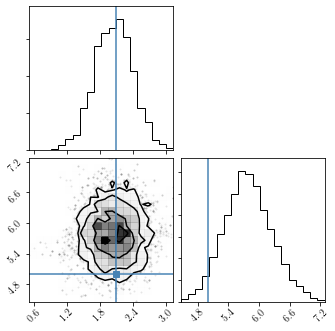

In [35]:
# Another python package to do the plotting
import corner

corner.corner(samples, truths=np.array([slope_true, intercept_true]))
plt.show()

The 2-D histogram gives us the joint probability. The 1-dimensional histograms gives the marginal probability. That is, to get the marginal probability of, say, $m$, simply drop the $c$'s from the samples and vice versa.

Such plots could also tell us if two parameters are tightly correlated or if their posterior is of a weird shape.

### Visualizing the results: posterior predictive distribution

While constraints on the model parameters are useful and informative. We want to understand the effect of the model parameters on the observables (in this case, the $x$ and $y$ points). We have a linear model and sampled a set of slopes and intercepts. The way to plot the effect on the observables is to use the sampled slopes and intercepts and what that implies for the linear relation between $x$ and $y$.

In [36]:
# Get the sampled values of the slope and intercept

m_samples, c_samples = samples.T

m_samples = m_samples.reshape((len(m_samples),1))
c_samples = c_samples.reshape((len(c_samples),1))

In [37]:
# Value of y for each of these samples

y_samples = m_samples * x_plot.reshape((1,len(x_plot))) + c_samples

In [38]:
# Get the mean and the error on the inferred relation

y_sample_mean = np.mean(y_samples, axis=0)
y_1sigma_lower = np.percentile(y_samples, 16., axis=0)
y_1sigma_upper = np.percentile(y_samples, 84., axis=0)
y_2sigma_lower = np.percentile(y_samples, 2.5, axis=0)
y_2sigma_upper = np.percentile(y_samples, 97.5, axis=0)

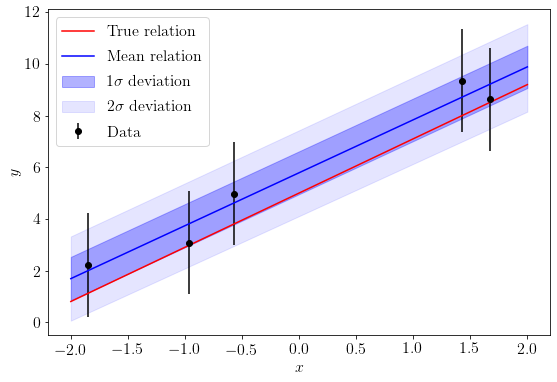

In [39]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.plot(x_plot, y_sample_mean, 'b', label='Mean relation')
plt.fill_between(x_plot, y_1sigma_lower, y_1sigma_upper, color='b', alpha=0.3, label='$1\sigma$ deviation')
plt.fill_between(x_plot, y_2sigma_lower, y_2sigma_upper, color='b', alpha=0.1, label='$2\sigma$ deviation')
plt.legend(fontsize=FONTSIZE)
plt.show()

We could also visualize this by plotting randomly sampled y-relations

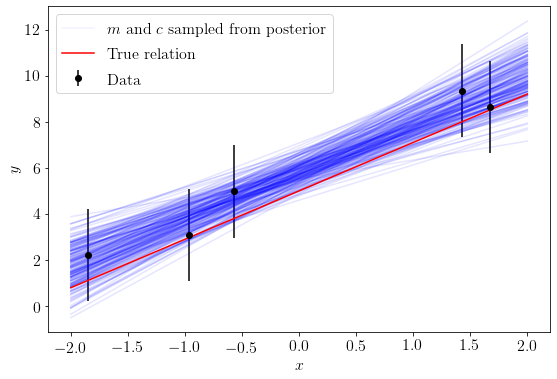

In [41]:
plt.figure(figsize=(9,6))
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
for i in range(200):
    ind = np.random.randint(0, y_samples.shape[0])
    if(i==0):
        plt.plot(x_plot, y_samples[ind], 'b', alpha=0.05, label='$m$ and $c$ sampled from posterior')
    plt.plot(x_plot, y_samples[ind], 'b', alpha=0.1)
plt.errorbar(x_data, y_data, 2., fmt='o', color='k', label='Data')
plt.plot(x_plot, slope_true * x_plot + intercept_true, 'r',label='True relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

### Next Lecture

- How to analyze the convergence of your MCMC run
    - Autocorrelation of the chains
    - Gelman-Rubin diagnostics
- Other MCMC algorithms:
    - Adaptive MH
    - Gibbs Sampling
    - Slice Sampling
    - Hamiltonian Monte Carlo
- Bayesian model comparison
- ......